## Assignment 2 - SVM and Signature Verification
created by krohak 2018-03-01

First, we import the necessary libraries:

In [1]:
import numpy as np
from matplotlib import (pyplot as plt, patches as patches)
from PIL import Image 
from skimage.filters import threshold_local 

import os
from os import listdir
from os.path import isfile, join

from scipy.ndimage.measurements import center_of_mass
from sklearn.metrics import accuracy_score
import scipy.misc

Some helper functions for Image processing utilities such as image binarization, normalization of the orientation, size and pixel value, etc.

In [2]:
# area of bounding box
def rotate_bbox_area(img, deg):
    box = img.rotate(deg, expand=True).getbbox()
    return (box[3] - box[1]) * (box[2] - box[0])
    
def rotate_crop(img, deg, padding=0):
    img_rotate = img.rotate(deg, expand=True, resample=Image.BILINEAR)
    box = img_rotate.getbbox()
    if padding > 0:
        box = np.asarray(box) + [-padding, -padding, +padding, +padding]
    return img_rotate.crop(box)


tol_deg = 1
# smallest bounding box wihin -10~10 degrees rotation
def opt_rotate(img, padding=0):
    opt_deg = np.argmin(
        [rotate_bbox_area(img, i) for i in range(-tol_deg,tol_deg+1)]
        ) - tol_deg
    return rotate_crop(img, opt_deg, padding)

# downsampling
def img_reduce(img, side=28, mode=Image.ANTIALIAS):
    h = side + 1 
    w = int(side * img.width / img.height) + 1
    img_reduced = img.copy()
    # the reduced image size is (w-1, h-1)
    img_reduced.thumbnail((w, h), mode)
    return img_reduced


# convert PIL.Image object to numpy.Array, for training
def img2arr(img):
    return np.asarray(img.getdata(), dtype=np.uint8).reshape(img.height, img.width, -1)


# process single signature with transparent background
def process_one(img):
    return img_reduce(opt_rotate(img, padding=1).convert('LA'))

## Data Preparation
The signature dataset is in the folder `original`. We need to divide this data into the genuine and forged signatures. I have created a Shell script called `arrange.sh` which arranges the signatures into two folders, `genuine` and `forged`.

In [3]:
os.system('pwd')
os.system('sh arrange.sh')

0

Loading the image paths:

In [4]:
path_gen = 'original/genuine/'
path_fog = 'original/forged/'
positiveFiles = [ path_gen + f for f in listdir(path_gen) if isfile(join(path_gen, f))]
negativeFiles = [ path_fog + f for f in listdir(path_fog) if isfile(join(path_fog, f))]

In [5]:
negativeFiles[0:5], positiveFiles[0:5]

(['original/forged/aae3b7f9-79a60013.png',
  'original/forged/a040d729-79a60013.png',
  'original/forged/2be9661a-79a60013.png',
  'original/forged/42a8bc0c-79a60013.png',
  'original/forged/89ea3e39-79a60013.png'],
 ['original/genuine/c01d34ed-bc.png',
  'original/genuine/4b595909-bc.png',
  'original/genuine/e8f0d83e-bc.png',
  'original/genuine/f16dfab5-bc.png',
  'original/genuine/2a77f79b-bc.png'])

In [6]:
num_files = len(positiveFiles)+len(negativeFiles)
print(num_files, len(positiveFiles), len(negativeFiles))

210 105 105


## Data Normalization

Next, We try to run the preprocessing on one of the positive files. We run `preprocess_one()` to crop and rotate the given signature as per the largest bounding box found and to downsample the image.

original/genuine/c01d34ed-bc.png
image size (255, 127)
reduced to (52, 28)


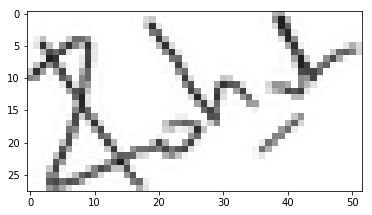

In [7]:
image_file = positiveFiles[0]
print(image_file)
img = Image.open(image_file).convert('LA')

print('image size', img.size)
img_reduced = process_one(img)
print('reduced to', img_reduced.size)

plt.imshow(img_reduced)
plt.show()

We then convert the PIL Image to an np array using `img2arr()` helper function:

In [8]:
img_arr = img2arr(img_reduced)[:,:,-1] # use the alpha channel, highter more opaque
print(img_arr.shape, img_arr.dtype)

(28, 52) uint8


Next, we standardize the final size of the np array by making it 28x28. We find the center of mass of the image and use the 28x28 square around it. Below is a step by step visualization of this process:

center of mass [ 14.  21.]
size (28, 28) range [0, 255] thresholded density 0.121173469388


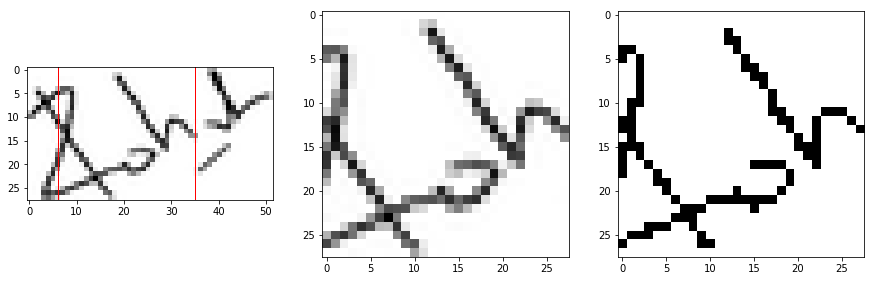

In [9]:
data = []
center = np.round(center_of_mass(img_arr))
print('center of mass', center)

plt.subplots(1,3,figsize=(15,5))
ax = plt.subplot(1,3,1)
plt.imshow(img_arr, cmap='gray_r')

h = img_arr.shape[0]
left = int(center[1]) - h//2
ax.add_patch(
    patches.Rectangle((left-1, -1), h+1, h+1,
                            linewidth=1, edgecolor='r', facecolor='none')
)

# we use the 28x28 square around the center of mass

mat = img_arr[:, left:left+h]
print('size', mat.shape, 'range', [mat.min(), mat.max()], 
      'thresholded density', (mat>127).sum()/(h*h))
plt.subplot(1,3,2)
plt.imshow(mat, cmap='gray_r')

plt.subplot(1,3,3)
plt.imshow(mat>127, cmap='gray_r')

plt.show()

mat = mat>17

data.append(mat)

We replicate the above steps in a loop to normalize and binarize all the images in our dataset. We concatenate the 28x28 array of each image to a feature vector of size 784. We append all feature vectors to the data list. We also append the labels (0 for forged and 1 for genuine) in another list. 

In [10]:
data = []
labels = []

for file_type, files in enumerate([negativeFiles,positiveFiles]):
    for image_file in files:
        
        # print(image_file,end='')

        img = Image.open(image_file).convert('LA')
        img_reduced = process_one(img)
        img_arr = img2arr(img_reduced)[:,:,-1]
        
#         28x28 box around the center of mass of signature
        center = np.round(center_of_mass(img_arr))
        h = img_arr.shape[0]
        left = int(center[1]) - h//2
        mat = img_arr[:, left:left+h]
        
#         to save all normalized images for viewing: 
        # scipy.misc.imsave('normalized/%s.jpg'%image_file.split('/')[2], mat)
        
#         binarize the image 
        mat = mat>127
        
#         plot the binarized images
        # plt.imshow(mat, cmap='gray_r')
        # plt.show()

        # convert from 28x28 to 784 
        mat = np.concatenate(mat)
        
        if (mat.shape == (784,)):
            data.append(mat)
            labels.append(file_type)
        else: 
            print("Removing %s from dataset"%image_file)

print("Normalized %s signature arrays with dimension %s"%(len(data),data[1].shape))

Normalized 210 signature arrays with dimension (784,)


Finally, we convert the lists into np arrays:

In [11]:
data_np = np.asarray(data)
data_np.shape

(210, 784)

In [12]:
labels = np.asanyarray(labels)
labels.shape

(210,)

## Training and Testing
First we import some additional modules for our SVM model. 

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, NuSVC

We shuffle the data before splitting it in 80-20, where 80 is for training our SVM model:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data_np, labels,  test_size=0.2 , random_state=np.random.seed(999557), shuffle=True)

First we try out different kernels of SVC such as Linear and RBF. We also try out the NuSVC model:

In [15]:
clf = SVC(kernel='linear')
clf.fit(X_train, y_train) 

y_pred = clf.predict(X_test)

score = accuracy_score(y_pred , y_test)*100
print(score)

92.8571428571


In [16]:
clf = NuSVC()
clf.fit(X_train, y_train) 

y_pred = clf.predict(X_test)

score = accuracy_score(y_pred , y_test)*100
print(score)

92.8571428571


In [17]:
clf = SVC()
clf.fit(X_train, y_train) 

y_pred = clf.predict(X_test)

score = accuracy_score(y_pred , y_test)*100
print(score)

92.8571428571


For precision and recall of our trained model, we can visualize the confusion matrix of `y_test` vs `y_pred`. We can also calculate the exact precision and recall using `precision_score` and `recall_score`

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[20,  1],
       [ 2, 19]])

In [19]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Precision Score: %s, Recall Score: %s"%(precision, recall))

Precision Score: 0.95, Recall Score: 0.904761904762


The F1 score is a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The formula for the F1 score is:

`F1 = 2 * (precision * recall) / (precision + recall)`

In [20]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print("F1 Score: %s"%f1)

F1 Score: 0.926829268293


## Experiments
### Randomized Search with Cross Validation
We can find out the best estimate for C and gamma, our hyperparameters for SVC using Randomized Search with Cross Validation:

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.01), "C": uniform(1, 10)}
clf = SVC()
rnd_search_cv = RandomizedSearchCV(clf, param_distributions, n_iter=10)
X_train, X_test, y_train, y_test = train_test_split(data_np, labels,  test_size=0.2 , random_state=np.random.seed(999554), shuffle=True)
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f365802a6a0>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f365802aba8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [22]:
rnd_search_cv.best_estimator_

SVC(C=10.976213775127844, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0089843691773399507,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [23]:
rnd_search_cv.best_score_

0.92261904761904767

In [24]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.97619047619047616

In [25]:
confusion_matrix(y_test,y_pred)

array([[22,  1],
       [ 0, 19]])

In [26]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Precision Score: %s, Recall Score: %s"%(precision, recall))

f1 = f1_score(y_test, y_pred)
print("F1 Score: %s"%f1)

Precision Score: 0.95, Recall Score: 1.0
F1 Score: 0.974358974359


### Random training-testing splits
We can also try out random testing and training splits for 100 iterations and see how our model performs on average. This time, we provide it the best estimate of C and gamma value obtained above:

In [27]:
# data_set, labels_set = shuffle(data_np, labels)
scores=[]
pred_list = []
test_list = []
iterations = 100
for i in range(iterations):
    X_train, X_test, y_train, y_test = train_test_split(data_np, labels,  test_size=0.2 , random_state=np.random.seed(), shuffle=True)

    clf = SVC(C=10,gamma=0.00898)
    clf.fit(X_train, y_train) 

    y_pred = clf.predict(X_test)
    
    score = accuracy_score(y_pred , y_test)*100
    #print(score)
    scores.append(score)
    pred_list.append(y_pred)
    test_list.append(y_test)
    
print('Average accuracy for %s random training batches: %s'%(iterations,sum(scores)/len(scores)))

Average accuracy for 100 random training batches: 93.2619047619


In [28]:
test_list = [item for sublist in test_list for item in sublist]
pred_list = [item for sublist in pred_list for item in sublist]
confusion_matrix(test_list,pred_list)/100

precision = precision_score(test_list, pred_list)
recall = recall_score(test_list, pred_list)
print("Precision Score: %s, Recall Score: %s"%(precision, recall))

f1 = f1_score(test_list, pred_list)
print("F1 Score: %s"%f1)

Precision Score: 0.925662878788, Recall Score: 0.939452186449
F1 Score: 0.93250655855
